In [1]:
from functools import reduce

from cycler import cycler
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from numbers import Number
import numpy as np
import pandas as pd
#from scipy import stats as sstats
import wmfdata as wmf
from wmfdata.utils import pct_str, sig_figs

import gspread
from google.oauth2.service_account import Credentials

In [2]:
FILE = "metrics/metrics.tsv"
metrics = pd.read_csv(FILE, sep="\t", parse_dates=["month"]).set_index("month")

In [3]:
FILE = "metrics/diversity_metrics.tsv"
diversity_metrics = pd.read_csv(FILE, sep="\t", parse_dates=["month"]).set_index("month")

# Report

In [4]:
metrics_all = pd.concat([metrics, diversity_metrics], axis=1)
metrics_all  = metrics_all.loc[:,~metrics_all.columns.duplicated()]

In [5]:
report_order = [
    'interactions', 
        'total_pageview',
        'automated_pageviews',
        'desktop', 
        'mobileweb',
        'previews_seen',
    'unique_devices',
    # Diversity
    'gn_interactions',
    'gs_interactions'
    #'Mobile-heavy wikis'
    #'mh_interactions'
]

In [6]:
def fmt_num(x):
    if isinstance(x, Number) and not pd.isnull(x):
        x = sig_figs(x, 3)
        
        if x < 5:
            return pct_str(x)
        else:
            return "{:,.0f}".format(x)
    else:
        return x

def calc_rpt(ser):   
    cur = ser[-1]
    
    try:
        yr_prev = ser[-13]
        yoy_change = (cur / yr_prev) - 1
    except IndexError:
        yoy_change = None
    
        
    
    res = [cur, yoy_change]
    return pd.Series(
        [fmt_num(n) for n in res],
        index=["value", "yoy_change"]
    )

In [7]:
(
    metrics_all
    .apply(calc_rpt)
    .transpose()
    .reindex(report_order)
    .fillna("—")
)

,value,yoy_change
interactions,"20,100,000,000",12.6%
total_pageview,"18,600,000,000",14.0%
automated_pageviews,"2,770,000,000",34.5%
desktop,"5,560,000,000",-9.0%
mobileweb,"12,700,000,000",28.4%
previews_seen,"1,550,000,000",-1.8%
unique_devices,"1,520,000,000",-8.1%
gn_interactions,"14,700,000,000",7.2%
gs_interactions,"5,400,000,000",30.8%


Removed Google sheet code and moved it to an independent notebook in the repo

## Create Charts

Changing directory to:/srv/home/mayakpwiki/High-Level-Metrics/2023-metrics/July-2023-demo/key_product_metrics/wikicharts
Generating Content Interactions chart...


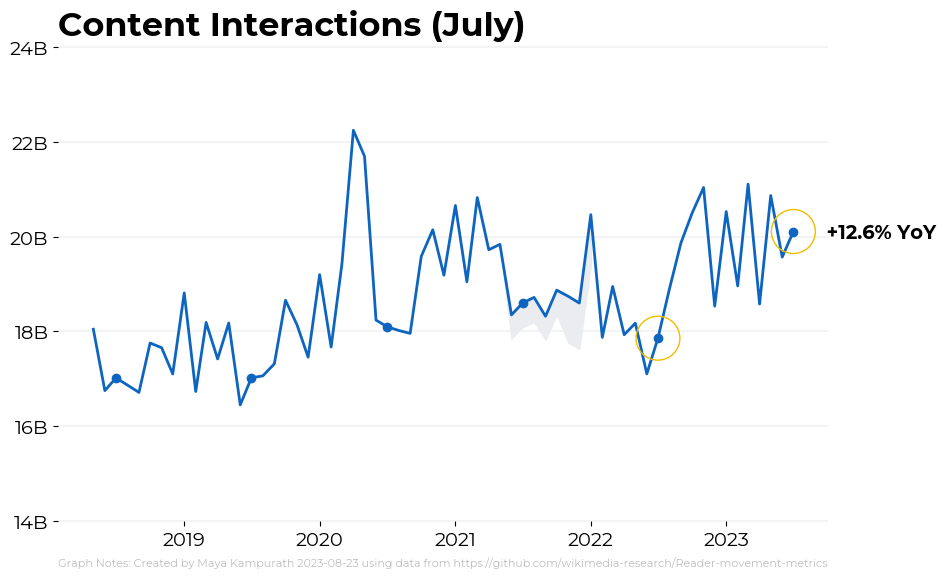

Generating Unique Devices chart...
Formatting may look incorrect in jupyter notebook window but the saved chart image will still be correct.


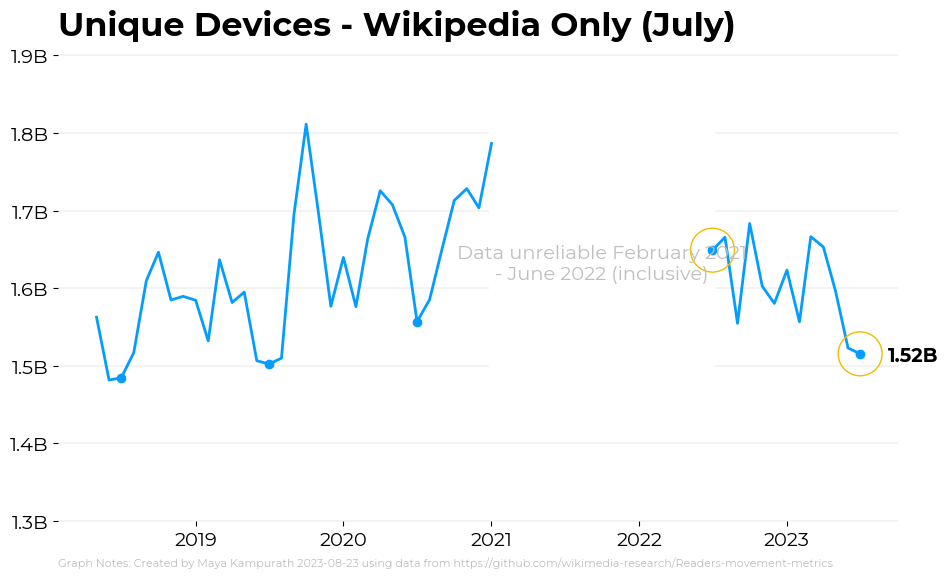

Generating Regional Unique Devices chart...
Formatting may look incorrect in jupyter notebook window but the saved chart image will still be correct.


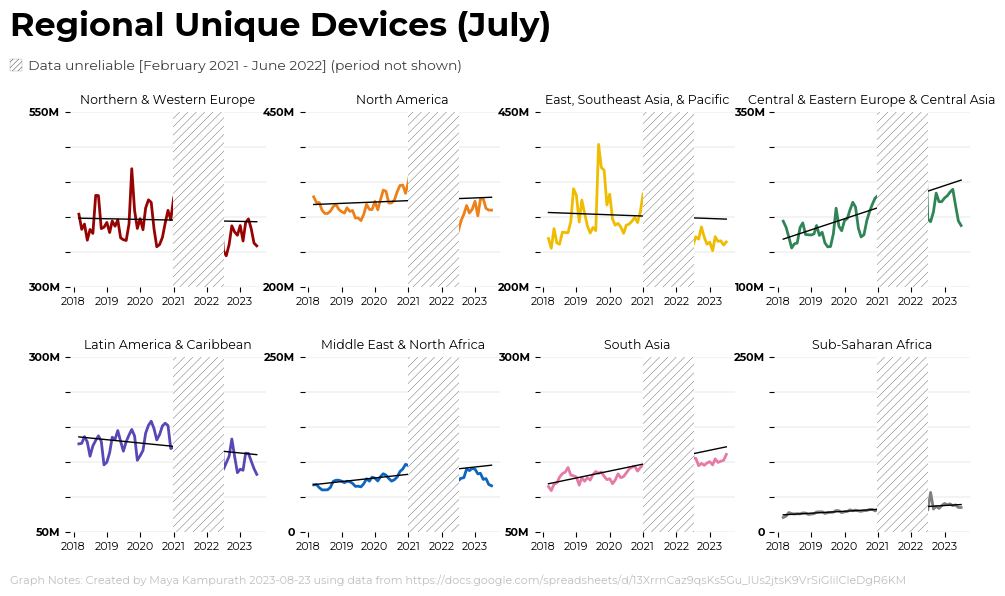

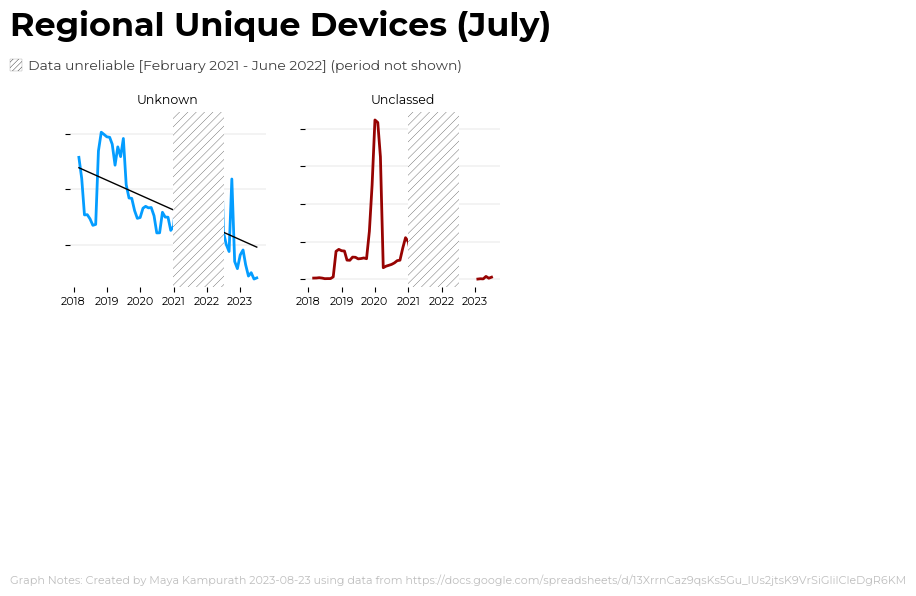

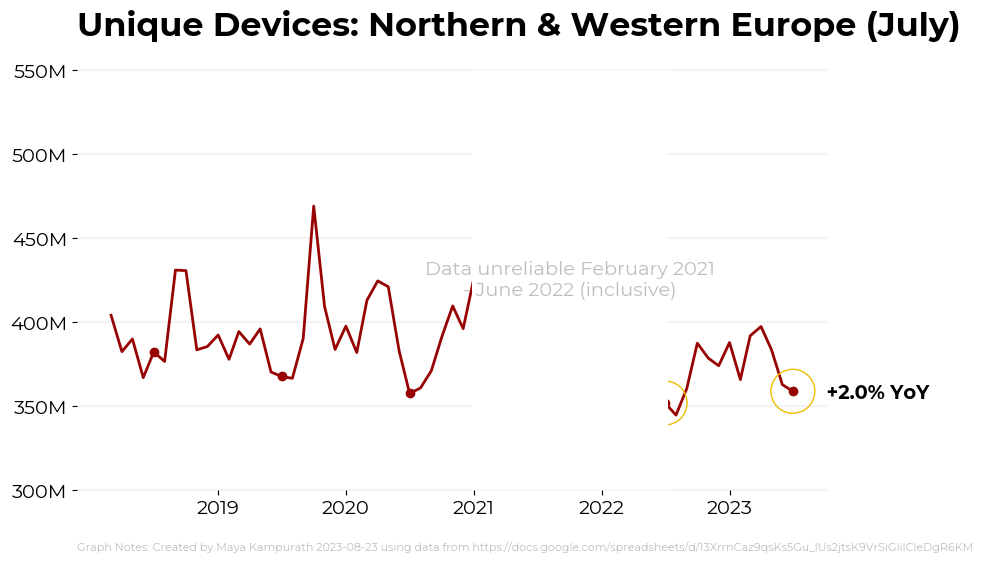

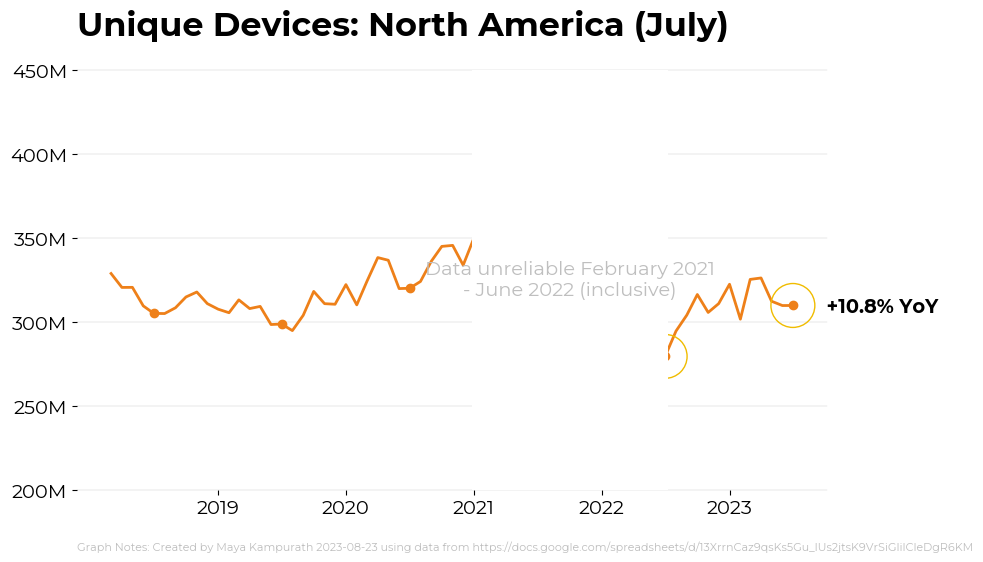

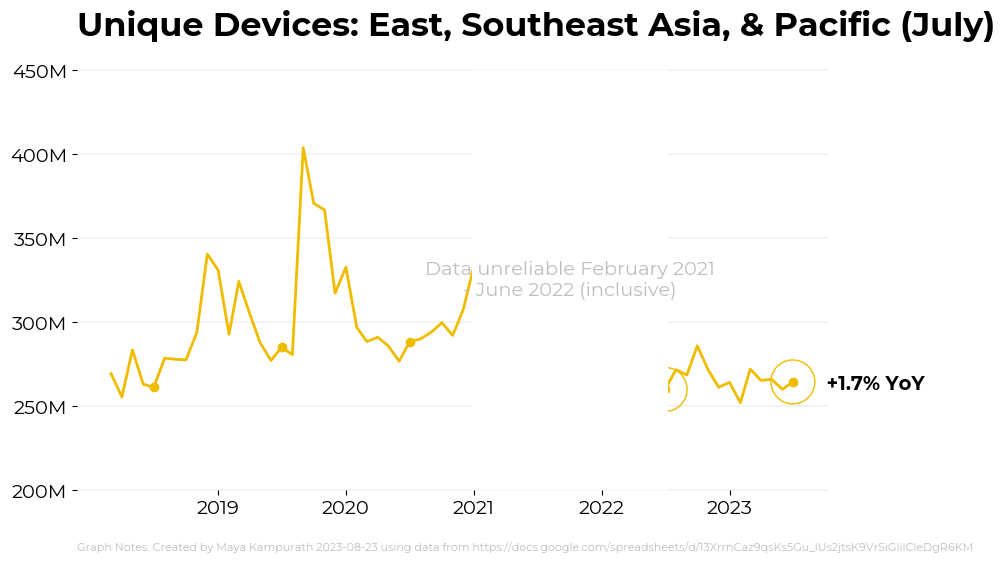

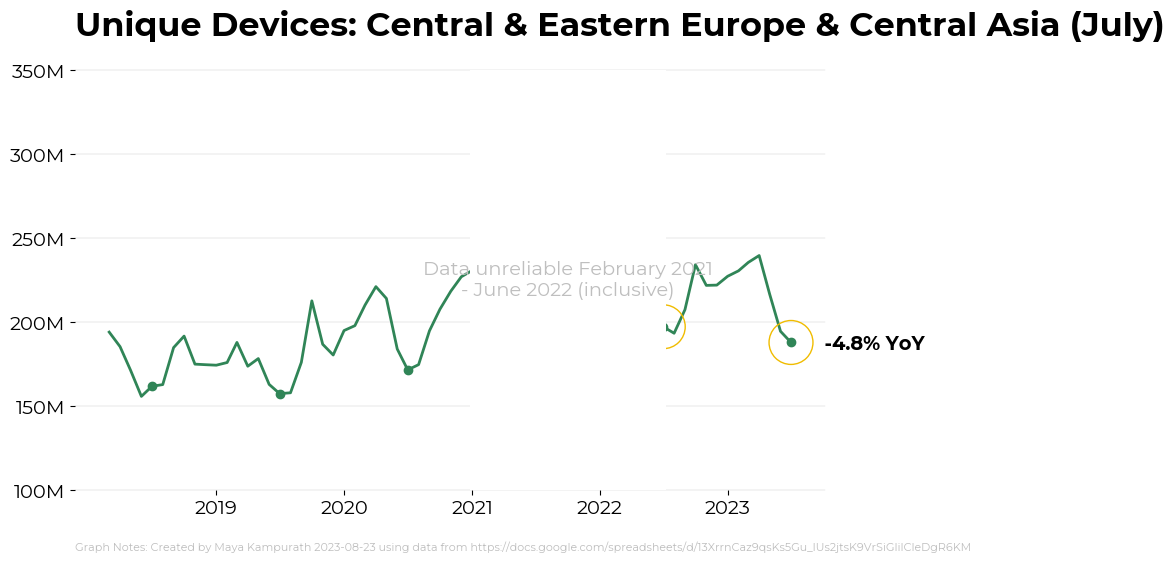

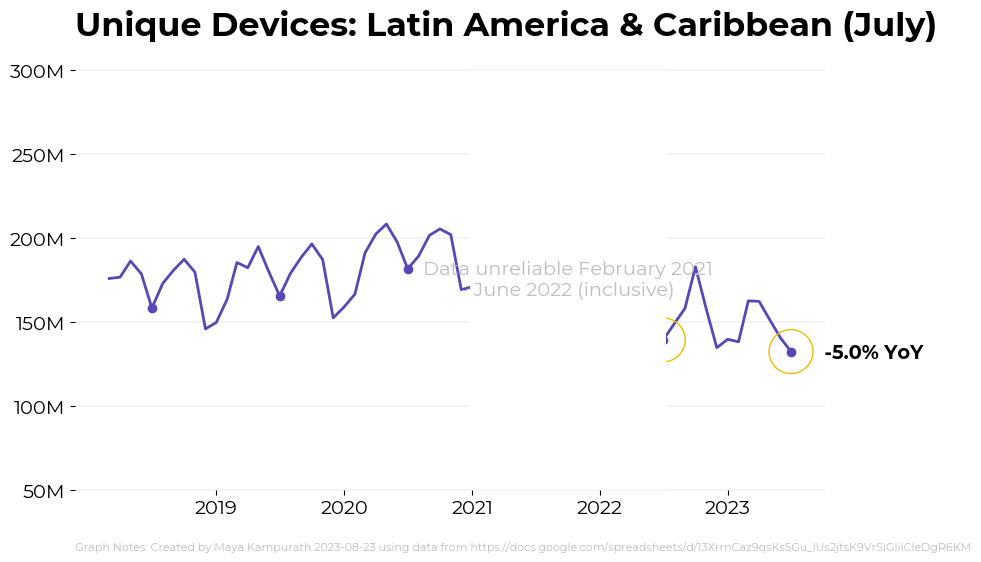

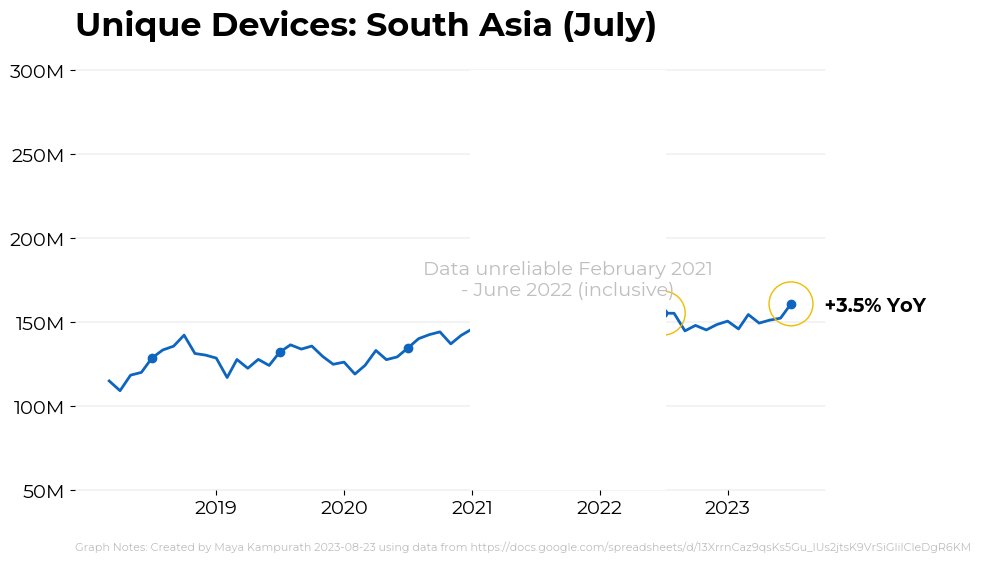

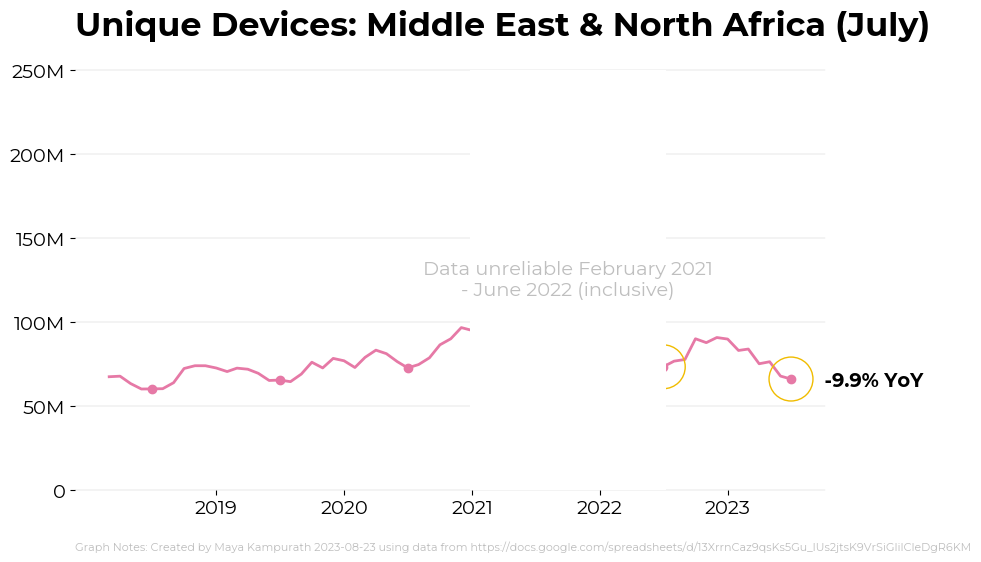

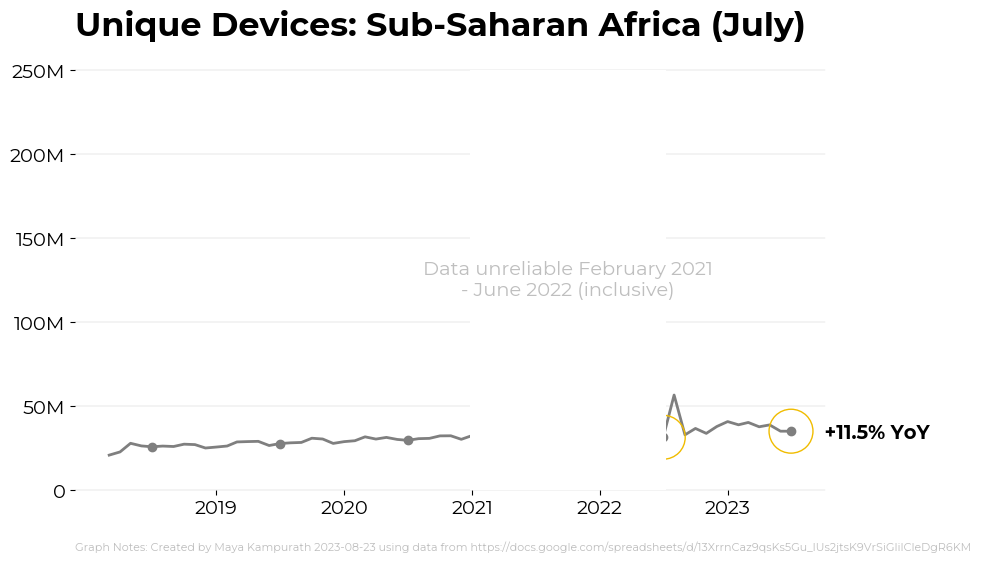

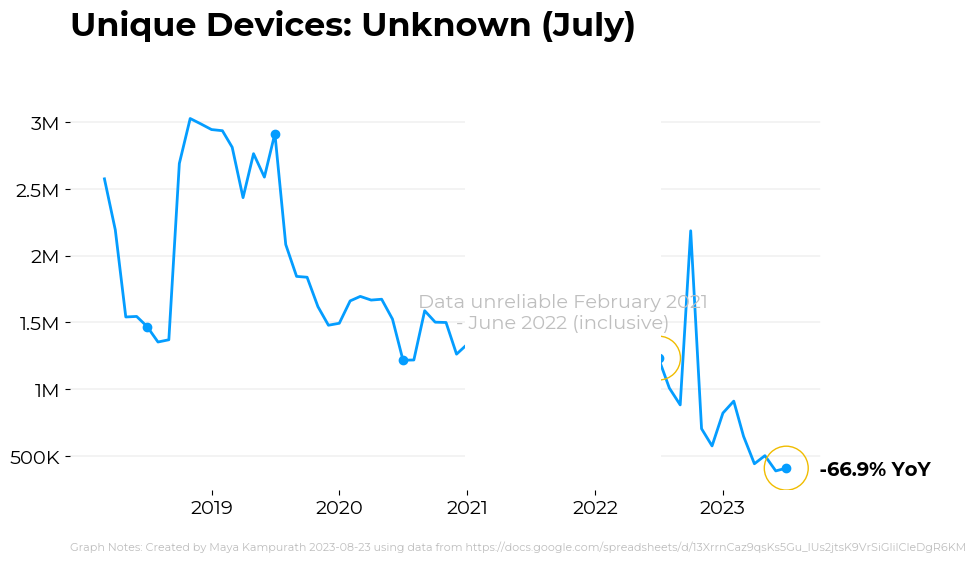

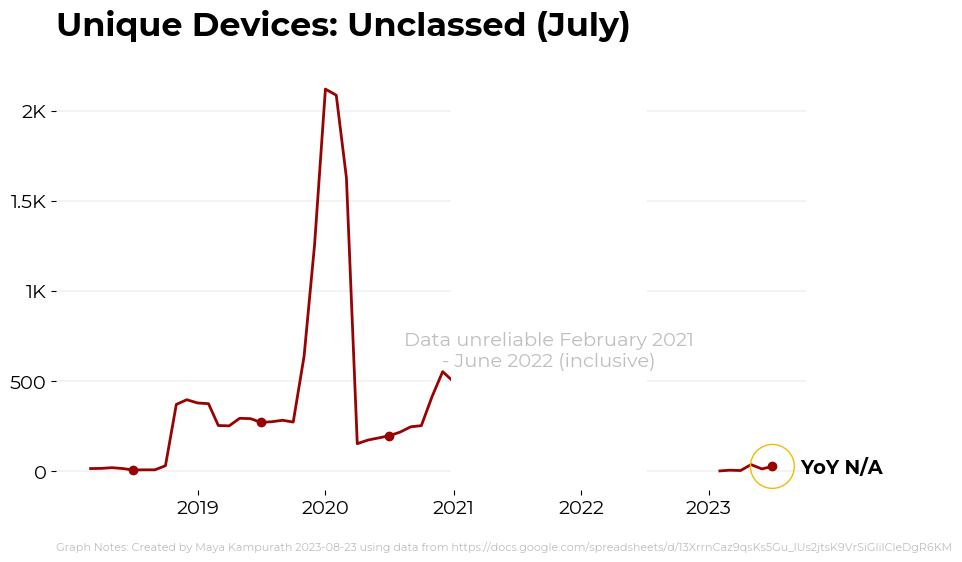

Resetting directory to:/srv/home/mayakpwiki/High-Level-Metrics/2023-metrics/July-2023-demo/key_product_metrics/wikicharts


In [10]:
# Using Hua's Viz code
%run ../key_product_metrics/wikicharts/READER_METRICS.ipynb